# Data Preparation

In [17]:
#import libraries
import tabulate
import pandas as pd
import seaborn as sns
import numpy as np

#preprocessing
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, RandomOverSampler

#normalization
from sklearn import preprocessing

#classification
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_val_predict, KFold, cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# bool columns in dataframe
global bool_columns
bool_columns = ['Smokes','Hormonal Contraceptives', 'IUD', 'STDs',
                'STDs:condylomatosis', 'STDs:cervical condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease', 
                'STDs:genital herpes', 'STDs:molluscum contagiosum',
                'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV',
                'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx']

# Function definitions

In [3]:
def meanImputation(df):
    """Data imputation using mean/mode of columns
    Following the methods described in: Razaliet al. (2020).
    Risk Factors of Cervical Cancer using Classification in Data Mining.
    Journal of Physics: Conference Series. 1529. 022102. 10.1088/1742-6596/1529/2/022102.

    Missing values for attribute that have integer data type were filled using the sample mean
    while boolean were filled using the sample mode.
    """
        
    # replace NaN with mode for columns with dtype bool
    for label, col in df.iteritems():
        if label in bool_columns:
            columns_mode = col.mode()
            # method 1
            df[label] = col.fillna(columns_mode[0])

            #convert column to bool while we're at it
            df[label] = df[label].astype('bool')

    float_columns = df.select_dtypes(include=['float64']).columns

    # replace NaN with mean for columns with dtype float
    for col in float_columns:
        columns_mean = df[col].mean()
        df[col] = df[col].fillna(columns_mean)
        
    return df

# Custom transformers

## Data imputation

Method 1: MeanImputationTransformer
Following the methods described in:
Razali, Nazim & Mostafa, Salama & Mustapha, Aida & Abd Wahab, Mohd Helmy & Ibrahim, Nurul. (2020). Risk Factors of Cervical Cancer using Classification in Data Mining. Journal of Physics: Conference Series. 1529. 022102. 10.1088/1742-6596/1529/2/022102. 

"Missing values for attribute that have integer data type were filled using the sample mean while boolean
were filled using the sample mode."

Method 2: UniqueValueImputationTransformer
Sets unique value -99 everywhere where data is missing. Value is chosen as it doesn't have any real-life meaning.

In [4]:
class MeanImputationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        #print("Mean value imputation called.")
        X_ = X.copy() # create copy to avoid changes to original dataset
        X_ = meanImputation(X_)
        return X_

In [5]:
class UniqueValueImputationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        #print("Unique value imputation called.")
        X_ = X.copy() # create copy to avoid changes to original dataset
        X_ = X_.fillna(-99)
        return X_

# Loading Dataset

In [6]:
# https://archive-beta.ics.uci.edu/ml/datasets/cervical+cancer+risk+factors
"""
The dataset was collected at 'Hospital Universitario de Caracas' in Caracas, Venezuela.
The dataset comprises demographic information, habits, and historic medical records of 858 patients.
Several patients decided not to answer some of the questions because of privacy concerns (missing values).
"""

rf = pd.read_csv('risk_factors_cervical_cancer.csv',encoding='utf8')
#rf.info()

# Covert data to usable datatypes

In [7]:
# replace missing values with NaN
rf = rf.replace('?',np.nan)

# covert everything to float64, some classes will be converted to bool once missing values are taken care of
for label, col in rf.iteritems():
    rf[label] = pd.to_numeric(col, errors='coerce')

#TODO: some things are still int after this and object types get transformed to bool automatically. But NaN values
#are not falsly converted to True so that should be okay.

# Examine data

## Check missing values per column

In [8]:
percent_missing = rf.isnull().sum() * 100 / len(rf)
missing_value_df = pd.DataFrame({'column_name': rf.columns,
                                 'percent_missing': percent_missing})

In [9]:
# remove columns with more than 20% missing
selection_columns = missing_value_df.loc[missing_value_df['percent_missing'] >= 20].iloc[:, 0]

for col in selection_columns:
    rf = rf.drop([col], axis=1)

## Check missing values per row

In [10]:
missing_count = []
for idx in range(len(rf)):
    missing = rf.loc[[idx]].isna().sum().sum()
    missing_count.append(missing)

removed = 0
for idx, val in enumerate(missing_count):
    # Remove all rows where more than 15% of the data are missing
    # If 20% is chosen, 106 patients are excluded
    if val >= len(rf.columns)*0.15:
        rf = rf.drop(idx)
        removed+=1
print("{} number of rows were removed".format(removed))

106 number of rows were removed


## Investigate class imbalances

In [11]:
# check if STDs (number) and STDs: Number of diagnosis are the same
STD_comparison = np.where((rf['STDs (number)']==rf['STDs: Number of diagnosis']), True, False)

# check manual calculation with STDs(number) if STDS (number) and STDs: Number of diagnosis not the same
if not STD_comparison.all():
    # create a new column with the sum of all STDs
    rf['STDs (number manual)'] = (rf['STDs:condylomatosis'] + rf['STDs:cervical condylomatosis'] +
        rf['STDs:vaginal condylomatosis'] + rf['STDs:vulvo-perineal condylomatosis'] +
        rf['STDs:syphilis'] + rf['STDs:pelvic inflammatory disease'] +
        rf['STDs:genital herpes'] + rf['STDs:molluscum contagiosum'] +
        rf['STDs:AIDS'] + rf['STDs:HIV'] +
        rf['STDs:Hepatitis B'] + rf['STDs:HPV'])
    
    # if they're the same drop the new column again
    manual_comp = np.where((rf['STDs (number)']==rf['STDs (number manual)']), True, False)
    if manual_comp.all():
        rf = rf.drop(['STDs (number manual)'], axis=1)

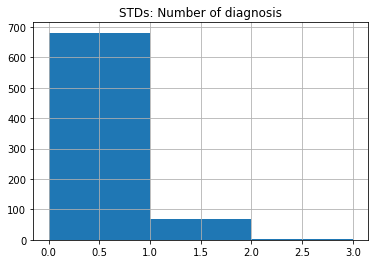

In [12]:
# we don't know exactly what this column
# as our goal is to create a transparent model we decided to exclude the column
rf = rf.drop(['STDs: Number of diagnosis'], axis=1)

# Classification

## Explainable boosting classifier metrics
## For pipelines with different oversampling and imputation methods

In [13]:
# split dataset in features and target variable
feature_cols = rf.columns[0:len(rf.columns)-4]
X = rf[feature_cols] # Features
y = rf.Biopsy # Target variable

In [14]:
cv = None # default 5-fold cross validation
#cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
#cv = KFold(n_splits=5)

In [15]:
# parameters for SMOTE oversampling
# for reproducibility purposes
seed = 100
# SMOTE number of neighbors
k = 1

In [26]:
# pipeline 1 using unique value imputation and random oversampling
pipe_1 = make_pipeline(SimpleImputer(fill_value=-99), RandomOverSampler('minority'), RandomForestClassifier())
scores_1 = cross_validate(pipe_1, X, y, cv=cv, scoring=['accuracy','roc_auc','f1', 'precision','recall'])

#y_pred_1 = cross_val_predict(pipe_1, X, y, cv=None) 
#confusion_matrix(y, y_pred_1)

Random oversampling, unique value imputation: 
accuracy: 0.9122295805739515
ROC AUC: 0.6165542371297767
f1: 0.10733893557422972
precision: 0.18333333333333332
recall: 0.07636363636363637 ]


In [33]:
# pipeline 2 using mean/mode value imputation and random oversampling

pipe_2 = make_pipeline(MeanImputationTransformer(), RandomOverSampler('minority'), RandomForestClassifier())
scores_2 = cross_validate(pipe_2, X, y, cv=cv, scoring=['accuracy','roc_auc','f1', 'precision','recall'])
scores_2

#y_pred_2 = cross_val_predict(pipe_2, X, y, cv=None) 
#confusion_matrix(y, y_pred_2)

Random oversampling,  mean/mode imputation: 
accuracy: 0.9175540838852096
ROC AUC: 0.6366207138185557
f1: 0.1387057387057387
precision: 0.26190476190476186
recall: 0.09636363636363636 ]


In [31]:
# pipeline 3 using unique value imputation and smote oversampling

sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)

pipe_3 = make_pipeline(SimpleImputer(fill_value=-99), sm, RandomForestClassifier())
scores_3 = cross_validate(pipe_3, X, y, cv=cv, scoring=['accuracy','roc_auc','f1', 'precision','recall'])
scores_3


#y_pred_3 = cross_val_predict(pipe_3, X, y, cv=None) 
#confusion_matrix(y, y_pred_3)

Random oversampling, unique value imputation: 
accuracy: 0.9135982339955848
ROC AUC: 0.5680833878351864
f1: 0.08333333333333334
precision: 0.18
recall: 0.05636363636363637 ]


In [32]:
# pipeline 3 using mean/mode imputation and smote oversampling

sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)

pipe_4 = make_pipeline(MeanImputationTransformer(), sm, RandomForestClassifier())
scores_4 = cross_validate(pipe_4, X, y, cv=cv, scoring=['accuracy','roc_auc','f1', 'precision','recall'])
scores_4

#y_pred_4 = cross_val_predict(pipe_4, X, y, cv=None) 
#confusion_matrix(y, y_pred_4)

SMOTE oversampling, mean/mode imputation: 
accuracy: 0.9109139072847683
ROC AUC: 0.5884434737923947
f1: 0.10285714285714287
precision: 0.16999999999999998
recall: 0.07636363636363637 ]


array([[679,  20],
       [ 49,   4]])

In [42]:
# All pipelines for Gradient Boosting

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                 max_depth=1, random_state=seed)
sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)

pipe_5 = make_pipeline(SimpleImputer(fill_value=-99), RandomOverSampler('minority'), clf)
scores_5 = cross_validate(pipe_5, X, y, cv=cv, scoring=['accuracy','roc_auc','f1', 'precision','recall'])
scores_5

pipe_6 = make_pipeline(MeanImputationTransformer(), RandomOverSampler('minority'), clf)
scores_6 = cross_validate(pipe_6, X, y, cv=cv, scoring=['accuracy','roc_auc','f1', 'precision','recall'])

pipe_7 = make_pipeline(SimpleImputer(fill_value=-99), sm, clf)
scores_7 = cross_validate(pipe_7, X, y, cv=cv, scoring=['accuracy','roc_auc','f1', 'precision','recall'])


pipe_8 = make_pipeline(MeanImputationTransformer(), sm, clf)
scores_8 = cross_validate(pipe_8, X, y, cv=cv, scoring=['accuracy','roc_auc','f1', 'precision','recall'])

#y_pred_4 = cross_val_predict(pipe_4, X, y, cv=None) 
#confusion_matrix(y, y_pred_4)

In [45]:
n_round = 3
data = [["Model","sampling","imputation","accuracy","roc_auc","f1","precision","recall"],
    ["Random forest","random", "unique", scores_1['test_accuracy'].mean().round(n_round), scores_1['test_roc_auc'].mean().round(n_round), scores_1['test_f1'].mean().round(n_round), scores_1['test_precision'].mean().round(n_round), scores_1['test_recall'].mean().round(n_round)],
    ["Random forest","random", "mean/mode", scores_2['test_accuracy'].mean().round(n_round), scores_2['test_roc_auc'].mean().round(n_round), scores_2['test_f1'].mean().round(n_round), scores_2['test_precision'].mean().round(n_round), scores_2['test_recall'].mean().round(n_round)],
    ["Random forest","SMOTE", "unique", scores_3['test_accuracy'].mean().round(n_round), scores_3['test_roc_auc'].mean().round(n_round), scores_3['test_f1'].mean().round(n_round), scores_3['test_precision'].mean().round(n_round), scores_3['test_recall'].mean().round(n_round)],
    ["Random forest","SMOTE", "mean/mode", scores_4['test_accuracy'].mean().round(n_round), scores_4['test_roc_auc'].mean().round(n_round), scores_4['test_f1'].mean().round(n_round), scores_4['test_precision'].mean().round(n_round), scores_4['test_recall'].mean().round(n_round)],
    ["Gradient boosting","random", "unique", scores_5['test_accuracy'].mean().round(n_round), scores_5['test_roc_auc'].mean().round(n_round), scores_5['test_f1'].mean().round(n_round), scores_5['test_precision'].mean().round(n_round), scores_5['test_recall'].mean().round(n_round)],
    ["Gradient boosting","random", "mean/mode", scores_6['test_accuracy'].mean().round(n_round), scores_6['test_roc_auc'].mean().round(n_round), scores_6['test_f1'].mean().round(n_round), scores_6['test_precision'].mean().round(n_round), scores_6['test_recall'].mean().round(n_round)],
    ["Gradient boosting","SMOTE", "unique", scores_7['test_accuracy'].mean().round(n_round), scores_7['test_roc_auc'].mean().round(n_round), scores_7['test_f1'].mean().round(n_round), scores_7['test_precision'].mean().round(n_round), scores_7['test_recall'].mean().round(n_round)],
    ["Gradient boosting","SMOTE", "mean/mode", scores_8['test_accuracy'].mean().round(n_round), scores_8['test_roc_auc'].mean().round(n_round), scores_8['test_f1'].mean().round(n_round), scores_8['test_precision'].mean().round(n_round), scores_8['test_recall'].mean().round(n_round)]]
table = tabulate.tabulate(data, tablefmt='html')
table

Model,sampling,imputation,accuracy,roc_auc,f1,precision,recall
Random forest,random,unique,0.912,0.617,0.107,0.183,0.076
Random forest,random,mean/mode,0.918,0.637,0.139,0.262,0.096
Random forest,SMOTE,unique,0.914,0.568,0.083,0.18,0.056
Random forest,SMOTE,mean/mode,0.911,0.588,0.103,0.17,0.076
Gradient boosting,random,unique,0.77,0.554,0.139,0.095,0.264
Gradient boosting,random,mean/mode,0.77,0.578,0.172,0.116,0.338
Gradient boosting,SMOTE,unique,0.87,0.534,0.131,0.147,0.133
Gradient boosting,SMOTE,mean/mode,0.854,0.555,0.139,0.123,0.171
